__author__ =  'Julia Schmid'

# FAIN93 SP IV Modul 3 - Forschungsprojekt Artificial Intelligence
## Identifikation von Bias bei ML-Modellen

### **Einstellungen**

In [606]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from gender_guesser.detector import Detector
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [607]:
# Alle Spalten eines Datensatzes anzeigen
pd.set_option('display.max_columns', None) 

# Float Zahlen ohne Wissenschaftliche Notation ausgeben (lesbarer)
pd.set_option('display.float_format', '{:.2f}'.format)


## **Daten einlesen und First Look**

In [608]:
# Quelle: https://www.kaggle.com/datasets/parisrohan/credit-score-classification?select=train.csv
df = pd.read_csv("train.csv")

/var/folders/jf/k1y_jzxs5177jm_fgv__dnww0000gn/T/ipykernel_50625/3866608427.py:2: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("train.csv")


In [609]:
# Ausgabe der Anzahl der Zeilen und Spalten
print(f'Anzahl Zeilen: {df.shape[0]}')
print(f'Anzahl Spalten: {df.shape[1]}')

Anzahl Zeilen: 100000
Anzahl Spalten: 28


In [610]:
# Anzeige der ersten 5 Zeilen
df.head()

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.84,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7,11.27,4.00,_,809.98,26.82,22 Years and 1 Months,No,49.57,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",-1,NaN,11.27,4.00,Good,809.98,31.94,NaN,No,49.57,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7,_,4.00,Good,809.98,28.61,22 Years and 3 Months,No,49.57,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",5,4,6.27,4.00,Good,809.98,31.38,22 Years and 4 Months,No,49.57,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.84,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",6,NaN,11.27,4.00,Good,809.98,24.80,22 Years and 5 Months,No,49.57,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good


In [611]:
# Anzeige der Informationen zu dein einezelnen Spalten
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  object 
 1   Customer_ID               100000 non-null  object 
 2   Month                     100000 non-null  object 
 3   Name                      90015 non-null   object 
 4   Age                       100000 non-null  object 
 5   SSN                       100000 non-null  object 
 6   Occupation                100000 non-null  object 
 7   Annual_Income             100000 non-null  object 
 8   Monthly_Inhand_Salary     84998 non-null   float64
 9   Num_Bank_Accounts         100000 non-null  int64  
 10  Num_Credit_Card           100000 non-null  int64  
 11  Interest_Rate             100000 non-null  int64  
 12  Num_of_Loan               100000 non-null  object 
 13  Type_of_Loan              88592 non-null   ob

In [612]:
# Bestimmung der Kategorische Variablen
categorical_var = [col for col in df if df[col].dtype == 'object']
print(categorical_var)

# Ausgea der vorkommenden Werte der kategeorischen Variable
for i in categorical_var:
    print(i)
    print(len(df[i].unique()))
    print(df[i].unique())
    print('')

''' 
Beobachtung: 
x - Vor und Nachname in einer Variable --> Später in zwei Variablen aufteilen'
x - Die nachfolgenden Variablen haben ein "_" bei den Zahlen stehen: Age, Annual_Income, Num_of_Loan, Num_of_Delayed_Payment, Changed_Credit_Limit, Outstanding_Debt
x - Die nachfolgendne Variablen sind als kategorischen anstatt einer numerischen Variable gespeichert:Age, Annual_Income, Num_of_Loan, Num_of_Delayed_Payment, Changed_Credit_Limit, Outstanding_Debt, Amount_invested_monthly, Monthly_Balance
x - Bei der Variable Occupation kann der Wert "_______" durch NaN-Wert ersetzt werden
x - Bei der Variable "Age" kommen negative Angaben (-500) oder extrem hohe Angaben (4808) vor, was nicht möglich ist. Diese Werte werden durch NaN-Werte ersetzt
x - Bei der Variable "Num_of_Delayed_Payment" kommen negative Angbane (-3) vor. Dies ist ebenfalls nicht möglich und die Werte werden durch NaN-Werte ersetzt
x - Bei der Variable "Credit_Mix" kann der Wert "_" durch NaN-Wert ersetzt werden
x - Für die Variable "Credit_History_Age" kann in die tatsächliche Monatsanzahl bestimmt werden
x - Bei "Payment_of_Min_Amount" ist zu prüfen, was der Wert "NM" bedeutet
x - Aus der Variable "Payment_Behaviour" wird der Wert "!@9#%8" durch NaN-Werte ersetzt 
x - Bei der Variable Type_of_Loan, wiederholen sich bestimmte Werte. Es muss untersucht werden, wie viele unique Werte vorliegen 
x - Die Variable Payment_Behaviour wird in Spent und ValuePayment aufgeteilt
'''

['ID', 'Customer_ID', 'Month', 'Name', 'Age', 'SSN', 'Occupation', 'Annual_Income', 'Num_of_Loan', 'Type_of_Loan', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Credit_Mix', 'Outstanding_Debt', 'Credit_History_Age', 'Payment_of_Min_Amount', 'Amount_invested_monthly', 'Payment_Behaviour', 'Monthly_Balance', 'Credit_Score']
ID
100000
['0x1602' '0x1603' '0x1604' ... '0x25feb' '0x25fec' '0x25fed']

Customer_ID
12500
['CUS_0xd40' 'CUS_0x21b1' 'CUS_0x2dbc' ... 'CUS_0xaf61' 'CUS_0x8600'
 'CUS_0x942c']

Month
8
['January' 'February' 'March' 'April' 'May' 'June' 'July' 'August']

Name
10140
['Aaron Maashoh' nan 'Rick Rothackerj' ... 'Chris Wickhamm'
 'Sarah McBridec' 'Nicks']

Age
1788
['23' '-500' '28_' ... '4808_' '2263' '1342']

SSN
12501
['821-00-0265' '#F%$D@*&8' '004-07-5839' ... '133-16-7738' '031-35-0942'
 '078-73-5990']

Occupation
16
['Scientist' '_______' 'Teacher' 'Engineer' 'Entrepreneur' 'Developer'
 'Lawyer' 'Media_Manager' 'Doctor' 'Journalist' 'Manager' 'Accountant'
 'Musi

' \nBeobachtung: \nx - Vor und Nachname in einer Variable --> Später in zwei Variablen aufteilen\'\nx - Die nachfolgenden Variablen haben ein "_" bei den Zahlen stehen: Age, Annual_Income, Num_of_Loan, Num_of_Delayed_Payment, Changed_Credit_Limit, Outstanding_Debt\nx - Die nachfolgendne Variablen sind als kategorischen anstatt einer numerischen Variable gespeichert:Age, Annual_Income, Num_of_Loan, Num_of_Delayed_Payment, Changed_Credit_Limit, Outstanding_Debt, Amount_invested_monthly, Monthly_Balance\nx - Bei der Variable Occupation kann der Wert "_______" durch NaN-Wert ersetzt werden\nx - Bei der Variable "Age" kommen negative Angaben (-500) oder extrem hohe Angaben (4808) vor, was nicht möglich ist. Diese Werte werden durch NaN-Werte ersetzt\nx - Bei der Variable "Num_of_Delayed_Payment" kommen negative Angbane (-3) vor. Dies ist ebenfalls nicht möglich und die Werte werden durch NaN-Werte ersetzt\nx - Bei der Variable "Credit_Mix" kann der Wert "_" durch NaN-Wert ersetzt werden\nx 

## **Datenaufbereitung**

**Katgeorische Variablen (basierend auf den Beobachtungen)**

In [613]:
# Beobachtung: Vor und Nachname in einer Variable --> Später in zwei Variablen aufteilen'

def getVorname(name):
    if pd.isna(name) or not isinstance(name, str):  
        return None
    return name.split()[0]  # Ersten Vornamen extrahieren
df["FirstName"] = df["Name"].apply(getVorname)


def getNachname(name):
    if pd.isna(name) or not isinstance(name, str):  
        return None
    parts = name.split()
    return parts[1] if len(parts) > 1 else None  
df["LastName"] = df["Name"].apply(getNachname)

In [614]:
# Beobachtung: Die nachfolgenden Variablen haben ein "_" bei den Zahlen stehen: Age, Annual_Income, Num_of_Loan, Num_of_Delayed_Payment, Changed_Credit_Limit, Outstanding_Debt

df['Age'] = df['Age'].str.replace('_', '')
df['Annual_Income'] = df['Annual_Income'].str.replace('_', '')
df['Num_of_Loan'] = df['Num_of_Loan'].str.replace('_', '')
df['Num_of_Delayed_Payment'] = df['Num_of_Delayed_Payment'].str.replace('_', '')
df['Changed_Credit_Limit'] = df['Changed_Credit_Limit'].str.replace('_', '')
df['Outstanding_Debt'] = df['Outstanding_Debt'].str.replace('_', '')

In [615]:
# Beobachtung: Die nachfolgendne Variablen sind als kategorischen anstatt einer numerischen Variable gespeichert:Age, Annual_Income, Num_of_Loan, Num_of_Delayed_Payment, Changed_Credit_Limit, Outstanding_Debt, Amount_invested_monthly, Monthly_Balance

list_col_int = ['Age', 'Annual_Income', 'Num_of_Loan', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Outstanding_Debt', 'Amount_invested_monthly', 'Monthly_Balance']

for i in list_col_int:
    print(i)
    df[i] = df[i].apply(pd.to_numeric, errors='coerce')

Age
Annual_Income
Num_of_Loan
Num_of_Delayed_Payment
Changed_Credit_Limit
Outstanding_Debt
Amount_invested_monthly
Monthly_Balance


In [616]:
# Beobachtungen:
# - Bei der Variable Occupation kann der Wert "_______" durch NaN-Wert ersetzt werden
# - Bei der Variable "Credit_Mix" kann der Wert "_" durch NaN-Wert ersetzt werden
# - Aus der Variable "Payment_Behaviour" wird der Wert "!@9#%8" durch NaN-Werte ersetzt 

df['Occupation'] = df['Occupation'].replace('_______', np.nan)
df['Credit_Mix'] = df['Credit_Mix'].replace('_', np.nan)
df['Payment_Behaviour'] = df['Payment_Behaviour'].replace('!@9#%8', np.nan)

In [617]:
# Beobachtung: Für die Variable "Credit_History_Age" kann in die tatsächliche Monatsanzahl bestimmt werden

def calculateCreditHistoryAgeMonth(dauer):
    if pd.isna(dauer): 
        return np.nan
    jahre = 0
    monate = 0
    if 'Year' in dauer:
        jahre = int(dauer.split('Year')[0].strip())
    if 'Month' in dauer:
        monate = int(dauer.split('Month')[0].split('and')[-1].strip())
    return jahre * 12 + monate

df['Credit_History_Age_Month'] = df['Credit_History_Age'].apply(calculateCreditHistoryAgeMonth)

In [618]:
# Beobachtungen
# - Bei der Variable "Age" kommen negative Angaben (-500) oder extrem hohe Angaben (4808) vor, was nicht möglich ist. Diese Werte werden durch NaN-Werte ersetzt
# - Bei der Variable "Num_of_Delayed_Payment" kommen negative Angbane (-3) vor. Dies ist ebenfalls nicht möglich und die Werte werden durch NaN-Werte ersetzt

df = df[(df['Age'] >= 18)&(df['Age'] <= 85)]
df = df[df['Num_of_Delayed_Payment'] >= 0]

In [619]:
# Beobachtung: Bei "Payment_of_Min_Amount" ist zu prüfen, was der Wert "NM" bedeutet

print(df[df['Payment_of_Min_Amount']=='NM'].head())

# Da keine genauen Hinweise auf NM gibt, wird dieser Wert durch einen NaN-Wert ersetzt
df['Payment_of_Min_Amount'] = df['Payment_of_Min_Amount'].replace('NM', 'No')


        ID Customer_ID     Month             Name  Age          SSN  \
14  0x1614  CUS_0x21b1      July  Rick Rothackerj   28  004-07-5839   
26  0x1628  CUS_0xb891     March           Jasond   55  072-31-6145   
41  0x163f  CUS_0x95ee  February               Np   31  612-70-8987   
48  0x164a  CUS_0x284a   January           Nadiaq   33  411-51-0676   
50  0x164c  CUS_0x284a     March           Nadiaq   34  411-51-0676   

      Occupation  Annual_Income  Monthly_Inhand_Salary  Num_Bank_Accounts  \
14       Teacher       34847.84                    NaN                  2   
26  Entrepreneur       30689.89                2612.49                  2   
41           NaN       73928.46                5988.71                  4   
48        Lawyer      131313.40               11242.78                  0   
50        Lawyer      131313.40               10469.21                  0   

    Num_Credit_Card  Interest_Rate  Num_of_Loan  \
14                4              6            1   
26      

In [620]:
# Beobachtung: Bei der Variable Type_of_Loan, wiederholen sich bestimmte Werte. Es muss untersucht werden, wie viele unique Werte vorliegen 
unique_loan = set(df['Type_of_Loan']
                    .str.replace(' and ', ', ')  # "and" durch Komma ersetzen
                    .str.split(', ')  # Trennen der Werte
                    .explode())  #
print(unique_loan)

# Ausgabe sortiert:
# {'Home Equity Loan,', 'Home Equity Loan', 
#  'Student Loan', 'Student Loan,', 
#  'Personal Loan,', 'Personal Loan', 
#  'Not Specified,', 'Not Specified', 
#  'Credit-Builder Loan', 'Credit-Builder Loan,', 
#  'Payday Loan,',  'Payday Loan', 
#  nan, 
# 'Debt Consolidation Loan,', 'Debt Consolidation Loan',
#  'Mortgage Loan,', 'Mortgage Loan'}
#  'Auto Loan,', 'Auto Loan', 

df['Loan_DebtConsolidation'] = df['Type_of_Loan'].str.contains('Debt Consolidation Loan', case=False, na=False).astype(int)
df['Loan_Auto'] = df['Type_of_Loan'].str.contains('Auto Loan', case=False, na=False).astype(int)
df['Loan_Payday'] = df['Type_of_Loan'].str.contains('Payday Loan', case=False, na=False).astype(int)
df['Loan_HomeEquity'] = df['Type_of_Loan'].str.contains('Home Equity Loan', case=False, na=False).astype(int)
df['Loan_Student'] = df['Type_of_Loan'].str.contains('Student Loan', case=False, na=False).astype(int)
df['Loan_NotSpecified'] = df['Type_of_Loan'].str.contains('Not Specifiedn', case=False, na=False).astype(int)
df['Loan_Personal'] = df['Type_of_Loan'].str.contains('Personal Loan', case=False, na=False).astype(int)
df['Loan_CreditBuilder'] = df['Type_of_Loan'].str.contains('Credit-Builder Loan', case=False, na=False).astype(int)
df['Loan_Mortgage'] = df['Type_of_Loan'].str.contains('Mortgage Loan', case=False, na=False).astype(int)

df['Loan'] = df[['Loan_DebtConsolidation', 'Loan_Auto', 'Loan_Payday', 'Loan_HomeEquity', 'Loan_Student', 'Loan_NotSpecified', 'Loan_Personal', 'Loan_CreditBuilder', 'Loan_Mortgage']].sum(axis=1)


{'Home Equity Loan,', 'Student Loan', 'Student Loan,', 'Personal Loan,', 'Not Specified,', 'Credit-Builder Loan', 'Personal Loan', 'Payday Loan,', nan, 'Not Specified', 'Payday Loan', 'Debt Consolidation Loan,', 'Home Equity Loan', 'Debt Consolidation Loan', 'Mortgage Loan,', 'Auto Loan,', 'Auto Loan', 'Credit-Builder Loan,', 'Mortgage Loan'}


In [621]:
# Beobachtung: Die Variable Payment_Behaviour wird in Spent und ValuePayment aufgeteilt
df[['Spent', 'ValuePayments']] = df['Payment_Behaviour'].str.split('_', expand=True)[[0, 2]]


In [622]:
# Basierend auf dem Name wird das Geschlecht bestimmt

# Geschlechtsdetektor initialisieren
detector = Detector()

def get_gender(name):
    if pd.isna(name) or not isinstance(name, str):  
        return None
    # first_name = name.split()[0] # Vornamen
    gender = detector.get_gender(name)
    
    if gender in ["male", "mostly_male"]:
        return "M"
    elif gender in ["female", "mostly_female"]:
        return "F"
    else:
        return np.nan

df["Sex"] = df["FirstName"].apply(get_gender)

In [623]:
to_delete = ["LastName", "FirstName", "Month", "Payment_Behaviour", 'Name', 'ID', 'Customer_ID', 'SSN', 'Credit_History_Age', 'Type_of_Loan', 'Loan_DebtConsolidation', 'Loan_Auto', 'Loan_Payday', 'Loan_HomeEquity', 'Loan_Student', 'Loan_NotSpecified', 'Loan_Personal', 'Loan_CreditBuilder', 'Loan_Mortgage']
df = df.drop(columns=to_delete)

['Occupation', 'Credit_Mix', 'Payment_of_Min_Amount', 'Credit_Score', 'Spent', 'ValuePayments', 'Sex']


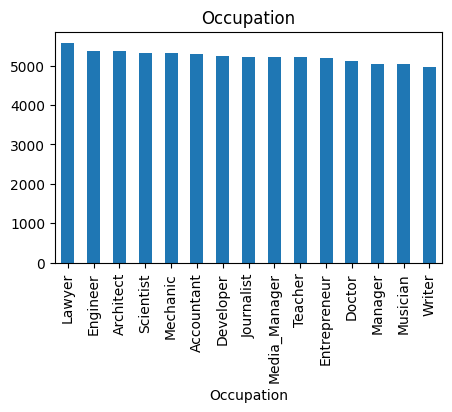

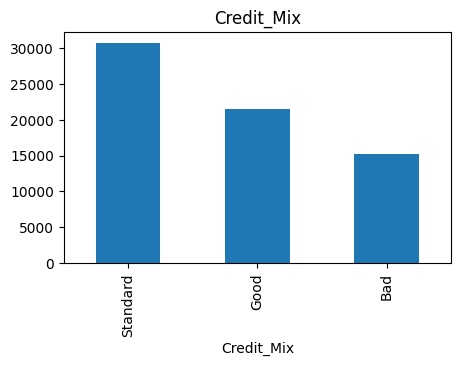

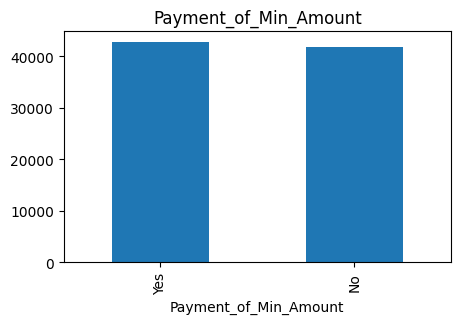

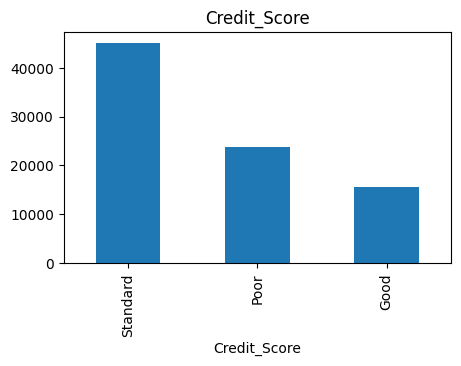

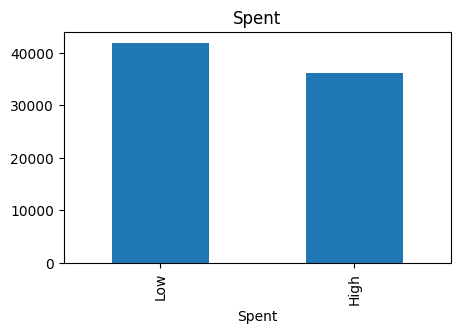

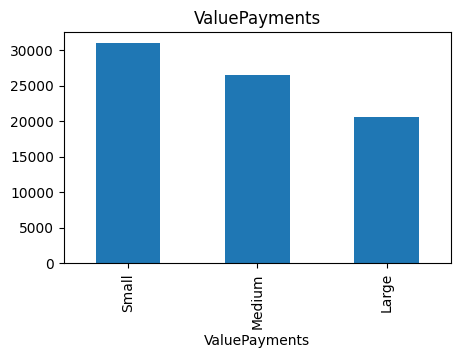

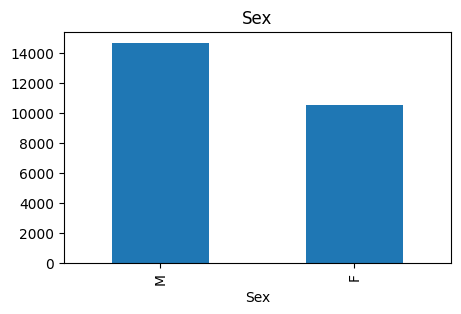

In [624]:
# Bestimmung der Kategorische Variablen
categorical_var_new = [col for col in df if df[col].dtype == 'object']
print(categorical_var_new)

# # Kategorische Variablen plotten 

skip_columns = ['FirstName', 'LastName', 'Type_of_Loan']

for i in categorical_var_new:
    if i in skip_columns:  
        continue
    plt.figure(figsize=(5, 3)) 
    df[i].value_counts().plot(kind='bar')
    plt.title(i)
    plt.show()

In [625]:
# ['', '', 'Payment_of_Min_Amount', '', '', '']

print(df['Credit_Score'].unique())
df['Credit_Score'] = df['Credit_Score'].replace({'Good': 1, 'Standard': 0, 'Poor': -1})

print(df['Credit_Mix'].unique())
df['Credit_Mix'] = df['Credit_Mix'].replace({'Good': 1, 'Standard': 0, 'Bad': -1})

print(df['Sex'].unique())
df['Sex'] = df['Sex'].replace({'M': 1, 'F': 0})

print(df['Occupation'].unique())
occupation_values = {
    "Entrepreneur": 1,
    "Engineer": 2,
    "Doctor": 3,
    "Lawyer": 4,
    "Manager": 5,
    "Scientist": 6,
    "Developer": 7,
    "Architect": 8,
    "Accountant": 9,
    "Media_Manager": 10,
    "Journalist": 11,
    "Writer": 12,
    "Musician": 13,
    "Teacher": 14,
    "Mechanic": 15,
}
df['Occupation'] = df['Occupation'].replace(occupation_values)

print(df['Spent'].unique())
df['Spent'] = df['Spent'].replace({'High': 1, 'Low': 0})

print(df['ValuePayments'].unique())
df['ValuePayments'] = df['ValuePayments'].replace({'Large': 2, 'Medium': 1, 'Small': 0})

print(df['Payment_of_Min_Amount'].unique())
df['Payment_of_Min_Amount'] = df['Payment_of_Min_Amount'].replace({'Yes': 1, 'No': 0})


['Good' 'Standard' 'Poor']
[nan 'Good' 'Standard' 'Bad']
['M' None nan 'F']
['Scientist' nan 'Teacher' 'Engineer' 'Entrepreneur' 'Developer' 'Lawyer'
 'Media_Manager' 'Doctor' 'Journalist' 'Manager' 'Accountant' 'Musician'
 'Mechanic' 'Writer' 'Architect']
['High' 'Low' nan]
['Small' nan 'Medium' 'Large']
['No' 'Yes']


/var/folders/jf/k1y_jzxs5177jm_fgv__dnww0000gn/T/ipykernel_50625/1550377583.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Credit_Score'] = df['Credit_Score'].replace({'Good': 1, 'Standard': 0, 'Poor': -1})
/var/folders/jf/k1y_jzxs5177jm_fgv__dnww0000gn/T/ipykernel_50625/1550377583.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Credit_Mix'] = df['Credit_Mix'].replace({'Good': 1, 'Standard': 0, 'Bad': -1})
/var/folders/jf/k1y_jzxs5177jm_fgv__dnww0000gn/T/ipykernel_50625/1550377583.py:10: FutureWarning: Downcasting

In [626]:
# df['FirstName'].value_counts()
# df['LastName'].value_counts()

In [627]:
''' 
Beobachtungen:
- Num_Bank_Account: Negative Angaben --> 0
- Num_of_Loan: Negativee Angaben --> 0
'''

df.describe()

,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Monthly_Balance,Credit_Score,Credit_History_Age_Month,Loan,Spent,ValuePayments,Sex
count,84424.00,78479.00,84424.00,71775.00,84424.00,84424.00,84424.00,84424.00,84424.00,84424.00,82659.00,82768.00,67341.00,84424.00,84424.00,84424.00,84424.00,77002.00,83425.00,84424.00,76787.00,84424.00,78081.00,78081.00,25214.00
mean,34.39,7.97,177112.77,4246.91,17.19,22.30,73.48,2.90,20.68,31.13,10.23,27.33,0.09,1390.35,32.32,0.51,1400.80,197.81,406.80,-0.10,225.11,2.45,0.46,0.87,0.58
std,10.10,4.32,1435707.46,3211.83,118.52,128.27,472.63,62.39,14.68,227.75,6.75,191.78,0.73,1142.93,5.12,0.50,8296.20,202.17,216.06,0.68,99.51,1.62,0.50,0.80,0.49
min,18.00,1.00,7006.03,303.65,-1.00,0.00,1.00,-100.00,-5.00,0.00,-6.48,0.00,-1.00,0.23,20.00,0.00,0.00,0.00,0.01,-1.00,1.00,0.00,0.00,0.00,0.00
25%,26.00,4.00,19662.27,1644.24,3.00,4.00,7.00,1.00,10.00,9.00,5.15,3.00,0.00,550.61,28.09,0.00,29.60,72.74,271.79,-1.00,150.00,1.00,0.00,0.00,0.00
50%,34.00,8.00,38038.59,3129.94,5.00,5.00,13.00,3.00,18.00,14.00,9.25,5.00,0.00,1127.35,32.36,1.00,68.31,130.08,339.87,0.00,224.00,2.00,0.00,1.00,1.00
75%,42.00,12.00,73716.20,6047.45,7.00,7.00,20.00,5.00,28.00,18.00,14.51,8.00,1.00,1854.48,36.53,1.00,159.32,239.43,476.77,0.00,307.00,4.00,1.00,2.00,1.00
max,56.00,15.00,24198062.00,15204.63,1798.00,1499.00,5797.00,1496.00,67.00,4397.00,36.97,2597.00,1.00,4998.07,50.00,1.00,82331.00,1977.33,1602.04,1.00,404.00,7.00,1.00,2.00,1.00


In [628]:
# Beobachtungen:
# - Num_Bank_Account: Negative Angaben --> 0
# - Num_of_Loan: Negativee Angaben --> 0

df['Num_of_Loan'] = df['Num_of_Loan'].apply(lambda x: max(x, 0))
df['Num_Bank_Accounts'] = df['Num_Bank_Accounts'].apply(lambda x: max(x, 0))

In [629]:
df.head()

,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Monthly_Balance,Credit_Score,Credit_History_Age_Month,Loan,Spent,ValuePayments,Sex
0,23,6.00,19114.12,1824.84,3,4,3,4,3,7.00,11.27,4.00,NaN,809.98,26.82,0,49.57,80.42,312.49,1,265.00,4,1.00,0.00,1.00
3,23,6.00,19114.12,NaN,3,4,3,4,5,4.00,6.27,4.00,1.00,809.98,31.38,0,49.57,199.46,223.45,1,268.00,4,0.00,0.00,1.00
5,23,6.00,19114.12,NaN,3,4,3,4,8,4.00,9.27,4.00,1.00,809.98,27.26,0,49.57,62.43,340.48,1,270.00,4,NaN,NaN,1.00
6,23,6.00,19114.12,1824.84,3,4,3,4,3,8.00,11.27,4.00,1.00,809.98,22.54,0,49.57,178.34,244.57,1,271.00,4,0.00,0.00,1.00
7,23,6.00,19114.12,1824.84,3,4,3,4,3,6.00,11.27,4.00,1.00,809.98,23.93,0,49.57,24.79,358.12,0,NaN,4,1.00,1.00,NaN


**Duplikate**

In [630]:
df.duplicated().sum()

# Keine Dupikate vorhanden

0

**NaN Werte**

In [631]:
count_nan = df.isna().sum()
count_nan[count_nan > 0]

df = df.dropna()

In [632]:
df.shape

(11539, 25)

In [633]:
df.head()

,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Monthly_Balance,Credit_Score,Credit_History_Age_Month,Loan,Spent,ValuePayments,Sex
6,23,6.00,19114.12,1824.84,3,4,3,4,3,8.00,11.27,4.00,1.00,809.98,22.54,0,49.57,178.34,244.57,1,271.00,4,0.00,0.00,1.00
9,28,14.00,34847.84,3037.99,2,4,6,1,7,1.00,7.42,2.00,1.00,605.03,38.55,0,18.82,40.39,484.59,1,320.00,1,1.00,2.00,1.00
12,28,14.00,34847.84,3037.99,2,4,6,1,3,1.00,6.42,2.00,1.00,605.03,34.98,0,18.82,130.12,444.87,1,323.00,1,0.00,0.00,1.00
13,28,14.00,34847.84,3037.99,2,4,6,1,3,0.00,5.42,2.00,1.00,605.03,33.38,0,18.82,43.48,481.51,1,324.00,1,1.00,2.00,1.00
15,28,14.00,34847.84,3037.99,2,4,6,1,3,4.00,5.42,2.00,1.00,605.03,32.93,0,18.82,218.90,356.08,1,326.00,1,0.00,0.00,1.00


In [634]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11539 entries, 6 to 99991
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       11539 non-null  int64  
 1   Occupation                11539 non-null  float64
 2   Annual_Income             11539 non-null  float64
 3   Monthly_Inhand_Salary     11539 non-null  float64
 4   Num_Bank_Accounts         11539 non-null  int64  
 5   Num_Credit_Card           11539 non-null  int64  
 6   Interest_Rate             11539 non-null  int64  
 7   Num_of_Loan               11539 non-null  int64  
 8   Delay_from_due_date       11539 non-null  int64  
 9   Num_of_Delayed_Payment    11539 non-null  float64
 10  Changed_Credit_Limit      11539 non-null  float64
 11  Num_Credit_Inquiries      11539 non-null  float64
 12  Credit_Mix                11539 non-null  float64
 13  Outstanding_Debt          11539 non-null  float64
 14  Credit_Util

## **Korrelationsmatrix**

['Age', 'Occupation', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Num_Credit_Inquiries', 'Credit_Mix', 'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Payment_of_Min_Amount', 'Total_EMI_per_month', 'Amount_invested_monthly', 'Monthly_Balance', 'Credit_Score', 'Credit_History_Age_Month', 'Loan', 'Spent', 'ValuePayments', 'Sex']


Text(0.5, 1.0, 'Correlation Matrix - Heatmap')

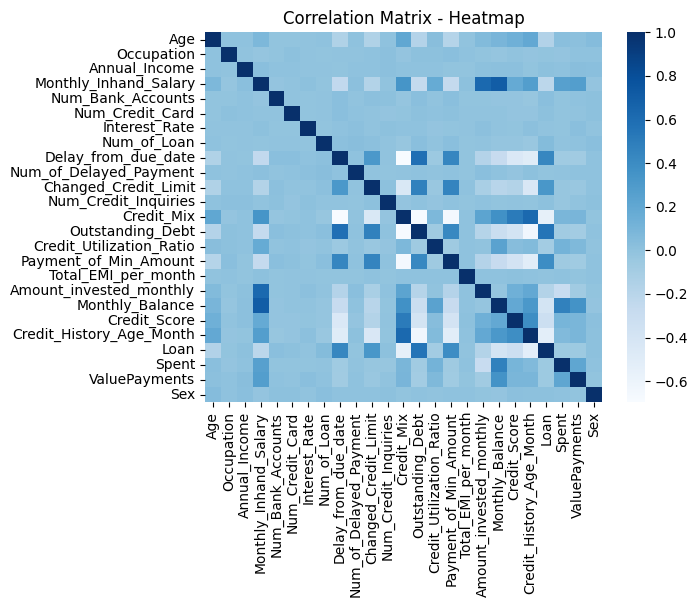

In [635]:
# Bestimmung der Kategorische Variablen
numerical_var_new = [col for col in df if df[col].dtype != 'object']
print(numerical_var_new)

corr_mat = df[numerical_var_new].corr()

# Heatmap erstellen
sns.heatmap(corr_mat, cmap='Blues')
plt.title('Correlation Matrix - Heatmap')

In [636]:
corr_mat['Credit_Score'].sort_values(ascending=False)

# Starke positive Korrelation (0,7 bis 1)
# Moderate positive Korrelation (0,3 bis 0,7)
# Schwache positive Korrelation (0 bis 0,3)
# Kein Zusammenhang (0)
# Schwache negative Korrelation (-0,3 bis 0)
# Moderate negative Korrelation (-0,7 bis -0,3)
# Starke negative Korrelation (-1 bis -0,7)

Credit_Score                1.00
Credit_Mix                  0.52
Credit_History_Age_Month    0.39
Monthly_Balance             0.20
Monthly_Inhand_Salary       0.18
Age                         0.14
Amount_invested_monthly     0.13
Spent                       0.10
ValuePayments               0.09
Credit_Utilization_Ratio    0.04
Annual_Income               0.02
Sex                         0.02
Total_EMI_per_month         0.01
Num_Credit_Inquiries       -0.00
Occupation                 -0.00
Interest_Rate              -0.01
Num_Bank_Accounts          -0.01
Num_of_Delayed_Payment     -0.02
Num_Credit_Card            -0.02
Num_of_Loan                -0.02
Changed_Credit_Limit       -0.17
Loan                       -0.32
Payment_of_Min_Amount      -0.38
Outstanding_Debt           -0.39
Delay_from_due_date        -0.45
Name: Credit_Score, dtype: float64

## **Modell**

In [639]:
X = df.drop(columns=['Credit_Score'])
y = df['Credit_Score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [640]:
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.6975736568457539
